In [1]:
import numpy as np
import warnings
import yadism
from yadbox.export import dump_pineappl_to_file
from eko import interpolation
import lhapdf
import pineappl
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Settings
methods = ["ele","da","jb","sig","esig"]
method = "ele"
eBeam = 10
pBeam = 250
beamConfig = f"{eBeam}x{pBeam}"
binning = 'StandardBinning' # 'HeraBinning' or 'StandardBinning'
lumi = 1. # Used to select table with the intended luminosity

# Load dataframe for desired config
data = pd.read_csv(f"../Tables/{binning}_{method}_Ee{eBeam}_Ep{pBeam}_lumi{lumi}fb-1_bins.csv")

In [3]:
data

,Q2,x,y,gen,rec,gen_rec,purity,stability
0,1.258925,0.000200,0.630957,1.676860e+07,9.138169e+06,7.946304e+06,0.869573,0.473880
1,1.258925,0.000316,0.398107,1.934272e+07,1.429938e+07,1.113560e+07,0.778747,0.575700
2,1.258925,0.000501,0.251189,2.035620e+07,1.947879e+07,1.149563e+07,0.590162,0.564724
3,1.258925,0.000794,0.158489,2.101816e+07,2.493319e+07,9.525359e+06,0.382035,0.453197
4,1.258925,0.001259,0.100000,2.071057e+07,2.728618e+07,6.214163e+06,0.227740,0.300048
...,...,...,...,...,...,...,...,...
149,1995.262315,0.501187,0.398107,1.182776e+03,6.771162e+02,5.257992e+02,0.776527,0.444547
150,1995.262315,0.794328,0.251189,9.579778e+01,1.177891e+02,3.919000e+01,0.332713,0.409091
151,3162.277660,0.501187,0.630957,5.715209e+02,2.389502e+02,2.008488e+02,0.840547,0.351429
152,3162.277660,0.794328,0.398107,4.354445e+01,3.537986e+01,1.469625e+01,0.415385,0.337500


In [4]:
theory_card = {
    # QCD perturbative order
    "PTO": 2,  # perturbative order in alpha_s: 0 = LO (alpha_s^0), 1 = NLO (alpha_s^1) ...

    # SM parameters and masses
    "CKM": "0.97428 0.22530 0.003470 0.22520 0.97345 0.041000 0.00862 0.04030 0.999152",  # CKM matrix elements
    "GF": 1.1663787e-05,  # [GeV^-2] Fermi coupling constant
    "MP": 0.938,  # [GeV] proton mass
    "MW": 80.398,  # [GeV] W boson mass
    "MZ": 91.1876,  # [GeV] Z boson mass
    "alphaqed": 0.007496252,  # alpha_em value
    "kcThr": 1.0,  # ratio of the charm matching scale over the charm mass
    "kbThr": 1.0,  # ratio of the bottom matching scale over the bottom mass
    "ktThr": 1.0,  # ratio of the top matching scale over the top mass
    "mc": 1.51,  # [GeV] charm mass
    "mb": 4.92,  # [GeV] bottom mass
    "mt": 172.5,  # [GeV] top mass

    # Flavor number scheme settings
    "FNS": "FONLL-FFNS",  # Flavour Number Scheme, options: "FFNS", "FFN0", "ZM-VFNS"
    "NfFF": 4,  # (fixed) number of running flavors, only for FFNS or FFN0 schemes
    "Q0": 1.65,  # [GeV] reference scale for the flavor patch determination
    "nf0": 4,  # number of active flavors at the Q0 reference scale

    # Alphas settings and boundary conditions
    "Qref": 91.2,  # [GeV] reference scale for the alphas value
    "nfref": 5,  # number of active flavors at the reference scale Qref
    "alphas": 0.118,  # alphas value at the reference scale
    "MaxNfAs": 5,  # maximum number of flavors in running of strong coupling
    "QED": 0,  # QED correction to running of strong coupling: 0 = disabled, 1 = allowed

    # Scale Variations
    "XIF": 1.0,  # ratio of factorization scale over the hard scattering scale
    "XIR": 1.0,  # ratio of renormalization scale over the hard scattering scale

    # Other settings
    "IC": 0,  # 0 = perturbative charm only, 1 = intrinsic charm allowed
    "TMC": 1,  # include target mass corrections: 0 = disabled, 1 = leading twist, 2 = higher twist approximated, 3 = higher twist exact
    "n3lo_cf_variation": 0,  # N3LO coefficient functions variation: -1 = lower bound, 0 = central , 1 = upper bound

    # Other EKO settings, not relevant for Yadism
    "HQ": "POLE",  # heavy quark mass scheme (not yet implemented in yadism)
    "MaxNfPdf": 5,  # maximum number of flavors in running of PDFs (ignored by yadism)
    "ModEv": "EXA",  # evolution solver for PDFs (ignored by yadism)
}

In [5]:
observables_card = {
    "PolarizationDIS": 0.0,
    "ProjectileDIS": "electron",
    "PropagatorCorrection": 0.0,
    "TargetDIS": "proton",
    "interpolation_is_log": True,
    "interpolation_polynomial_degree": 4,
    "interpolation_xgrid": interpolation.lambertgrid(60).tolist(),
    "observables": {"XSHERANC_total": []},
    "prDIS": "NC",
    "NCPositivityCharge": None,
}

In [6]:
def compute_predictions() -> None:
    """Compute yadism prediction for all experimental bins."""
    # prepare the kinematics for all the datapoints
    curobs = data.apply(
        lambda dat: {"x": dat["x"], "Q2": dat["Q2"], "y": dat["y"]},
        axis=1,
    )

    # Update the observable & kinematics in the `observable_card`
    obs_def = {
        "observables" : {"XSHERANC_total": list(curobs.to_dict().values())}
    } # As we saw in the previous tutorial, it has to be a dict[dict[list]]
    observables_card.update(obs_def)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # suppress noisy warnings
        out = yadism.run_yadism(theory_card, observables_card)

    # Save results to a PineAPPL grid
    #dump_pineappl_to_file(out, "Yadism_Predictions.pineappl.lz4", "XSHERANC_total")
    dump_pineappl_to_file(out, f"../PineAPPL_grids/Xsec_Predictions_ep_Ee{eBeam}_Ep{pBeam}.{binning}.pineappl.lz4", "XSHERANC_total")

In [7]:
# ONLY RUN IF GRID DOESN'T ALREADY EXIST IN ../PineAPPL_grids
# compute_predictions() 

┌────────────────────────────────────┐                                       
                                      │                                    │                                       
                                      │ __     __       _ _                │                                       
                                      │ \ \   / /      | (_)               │                                       
                                      │  \ \_/ /_ _  __| |_ ___ _ __ ___   │                                       
                                      │   \   / _` |/ _` | / __| '_ ` _ \  │                                       
                                      │    | | (_| | (_| | \__ \ | | | | | │                                       
                                      │    |_|\__,_|\__,_|_|___/_| |_| |_| │                                       
                                      │                                    │                                       
                                      └────────────────────────────────────┘

Plan

 • XSHERANC_total at 154 pts

Calculation

yadism took off! please stay tuned ...

Output()

[13:39:35] INFO     computing P_qq_0 - took: 0.422488 s                                      ]8;id=25341;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=129994;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_qg_0 - took: 0.308982 s                                      ]8;id=60361;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=366015;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[13:39:36] INFO     computing P_gq_0 - took: 0.545137 s                                      ]8;id=269690;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=922101;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_gg_0 - took: 0.408889 s                                      ]8;id=185484;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=217214;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[13:39:37] INFO     computing P_qq_1 - took: 0.530005 s                                      ]8;id=269252;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=660768;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[13:39:38] INFO     computing P_nsp_1 - took: 0.569654 s                                     ]8;id=996356;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=351978;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_nsm_1 - took: 0.654384 s                                     ]8;id=226001;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=643744;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[13:39:39] INFO     computing P_qq_0^2 - took: 0.588537 s                                    ]8;id=513431;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=499211;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_qg_0P_gq_0 - took: 0.388785 s                                ]8;id=752514;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=411074;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[13:39:40] INFO     computing P_qq_0P_qg_0 - took: 0.397896 s                                ]8;id=56764;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=865620;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_qg_0P_gg_0 - took: 0.342951 s                                ]8;id=111654;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=731169;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

took 488.17 s

In [8]:
data

,Q2,x,y,gen,rec,gen_rec,purity,stability
0,1.258925,0.000200,0.630957,1.676860e+07,9.138169e+06,7.946304e+06,0.869573,0.473880
1,1.258925,0.000316,0.398107,1.934272e+07,1.429938e+07,1.113560e+07,0.778747,0.575700
2,1.258925,0.000501,0.251189,2.035620e+07,1.947879e+07,1.149563e+07,0.590162,0.564724
3,1.258925,0.000794,0.158489,2.101816e+07,2.493319e+07,9.525359e+06,0.382035,0.453197
4,1.258925,0.001259,0.100000,2.071057e+07,2.728618e+07,6.214163e+06,0.227740,0.300048
...,...,...,...,...,...,...,...,...
149,1995.262315,0.501187,0.398107,1.182776e+03,6.771162e+02,5.257992e+02,0.776527,0.444547
150,1995.262315,0.794328,0.251189,9.579778e+01,1.177891e+02,3.919000e+01,0.332713,0.409091
151,3162.277660,0.501187,0.630957,5.715209e+02,2.389502e+02,2.008488e+02,0.840547,0.351429
152,3162.277660,0.794328,0.398107,4.354445e+01,3.537986e+01,1.469625e+01,0.415385,0.337500


LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0000.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #0, version 1; LHAPDF ID = 316900
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0001.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #1, version 1; LHAPDF ID = 316901
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0002.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #2, version 1; LHAPDF ID = 316902
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0003.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #3, version 1; LHAPDF ID = 316903
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0004.dat
NNPDF31_nnlo_as_0118_proton PDF set, m

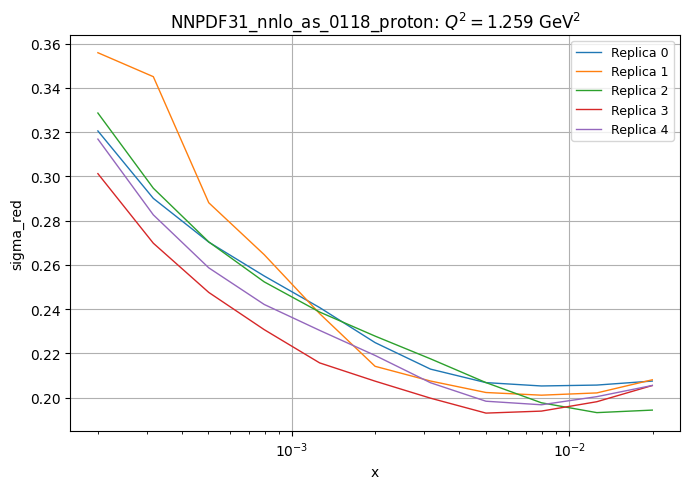

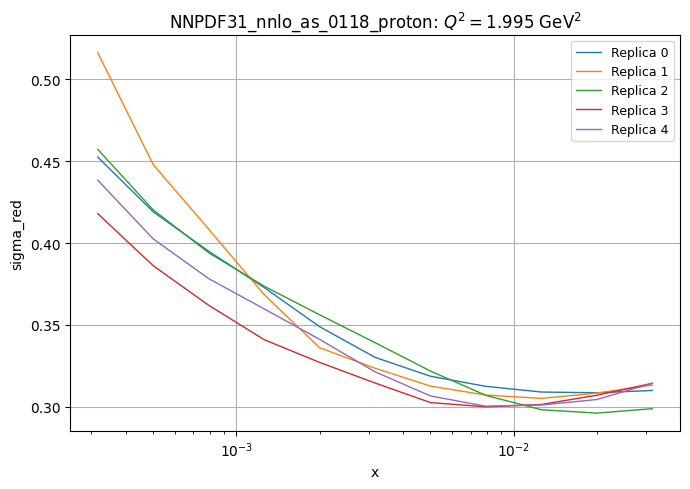

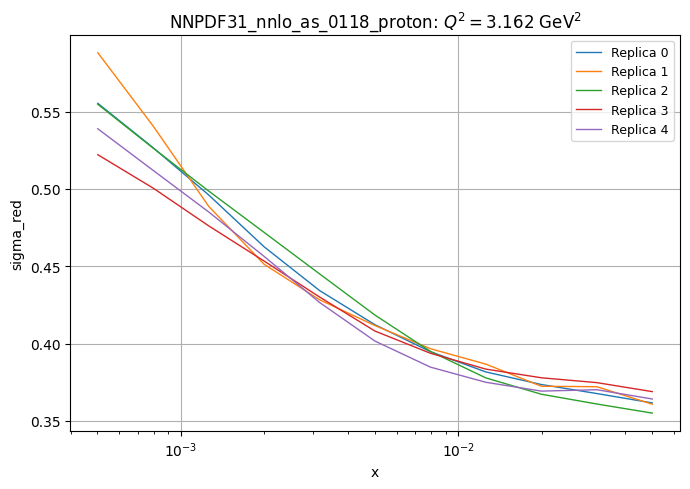

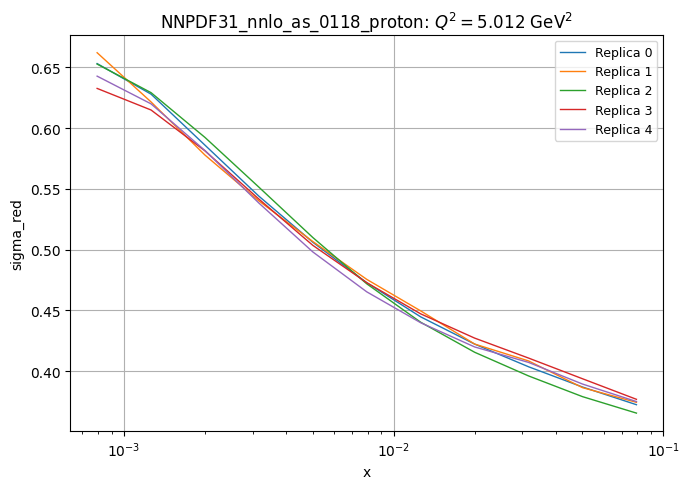

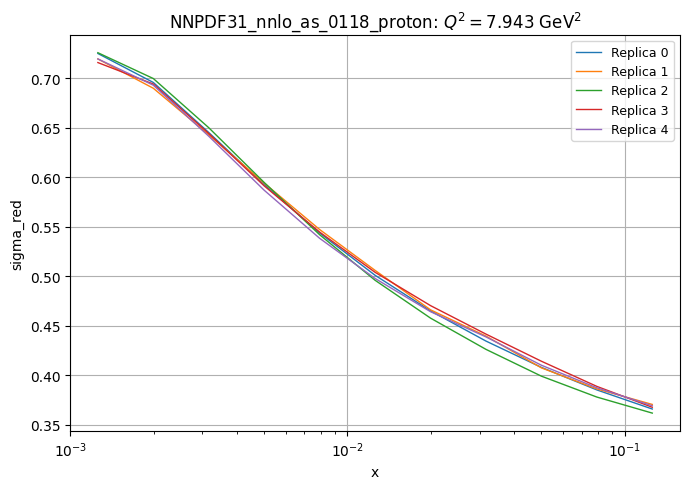

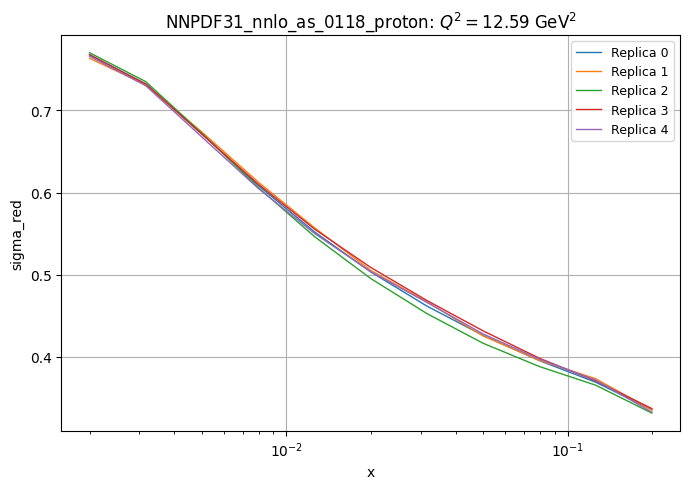

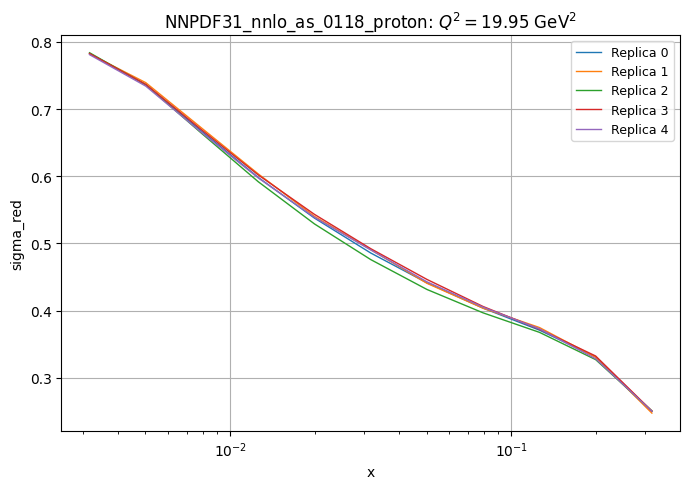

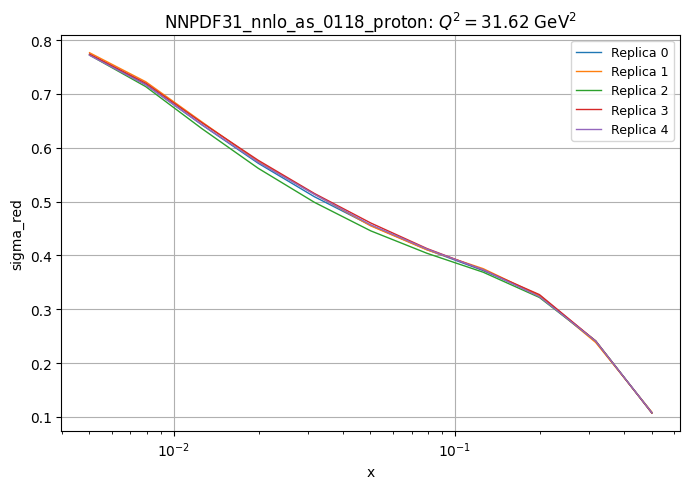

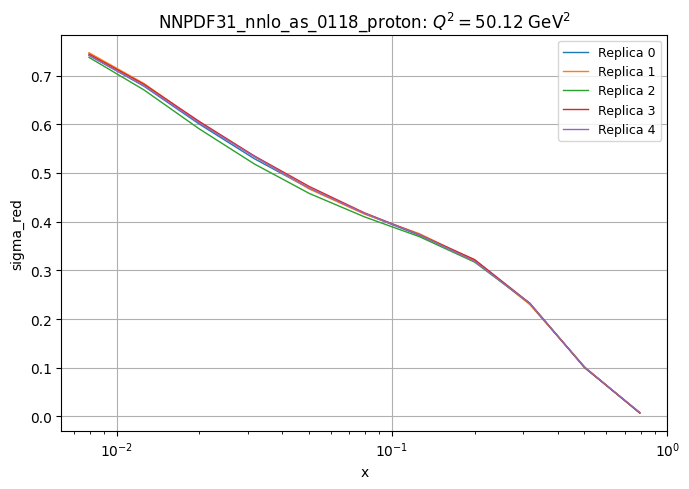

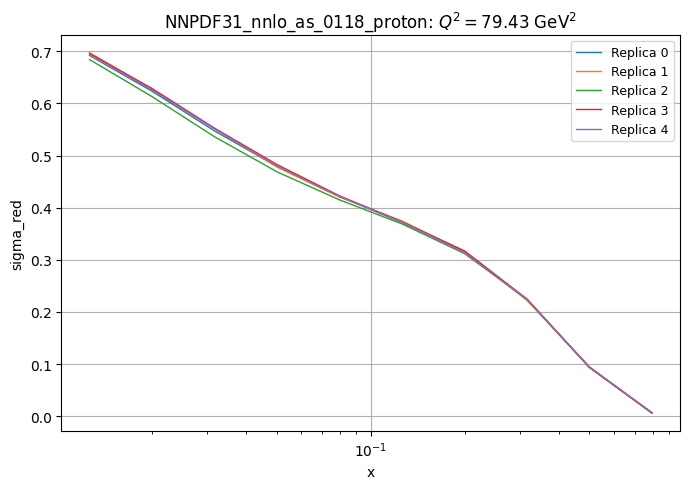

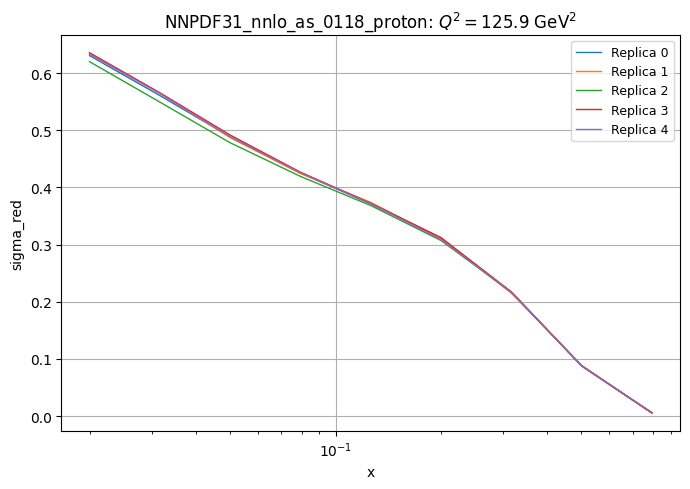

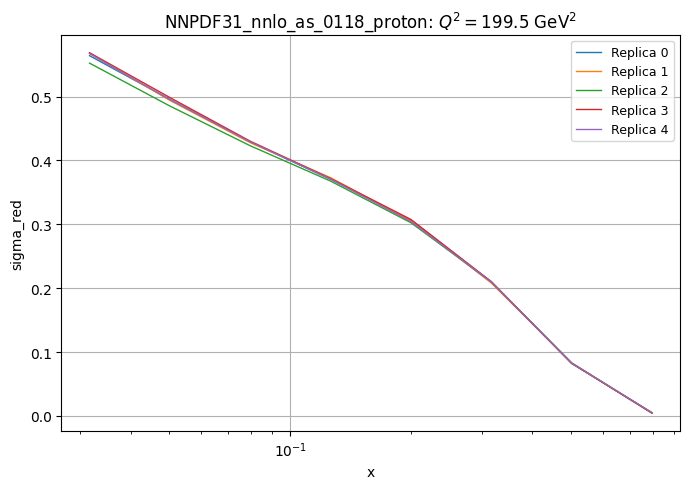

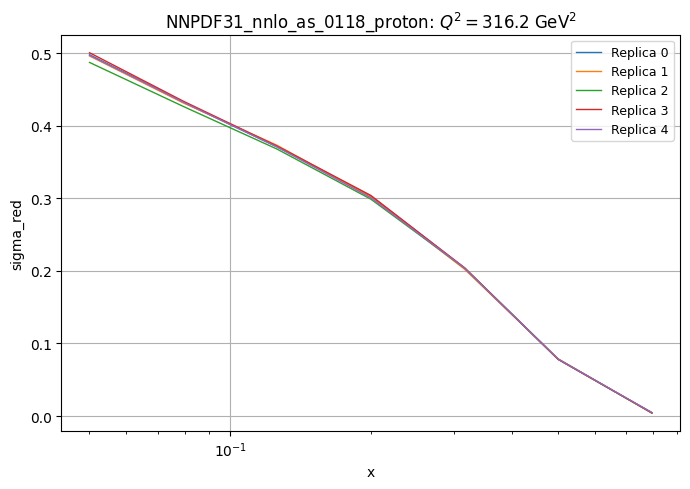

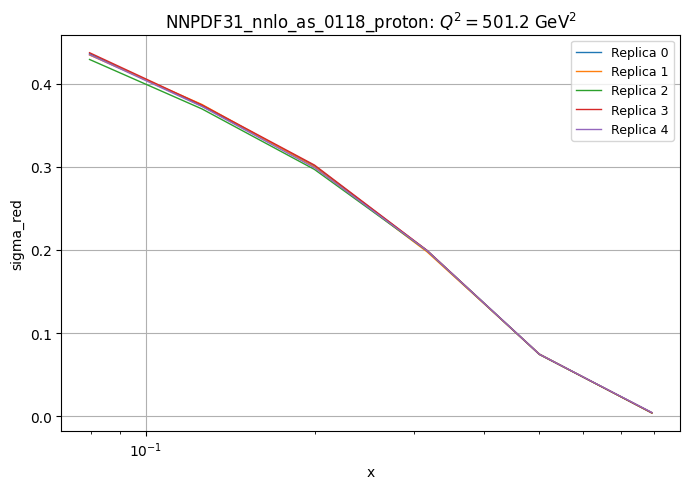

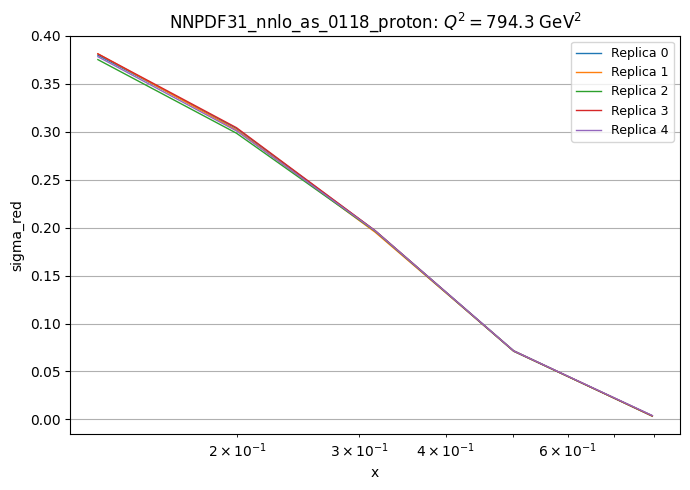

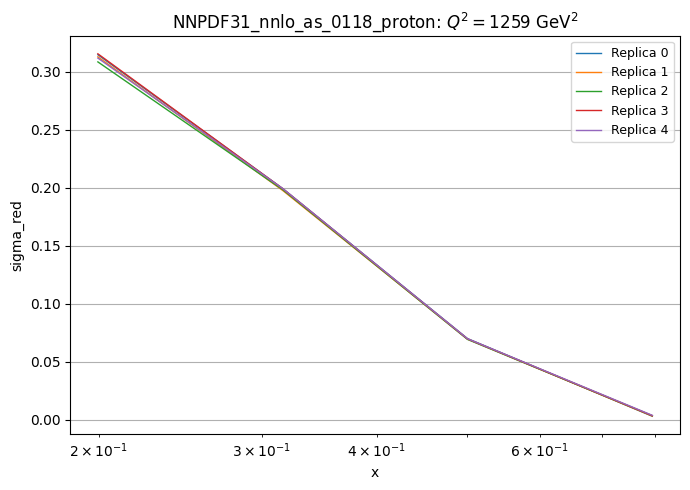

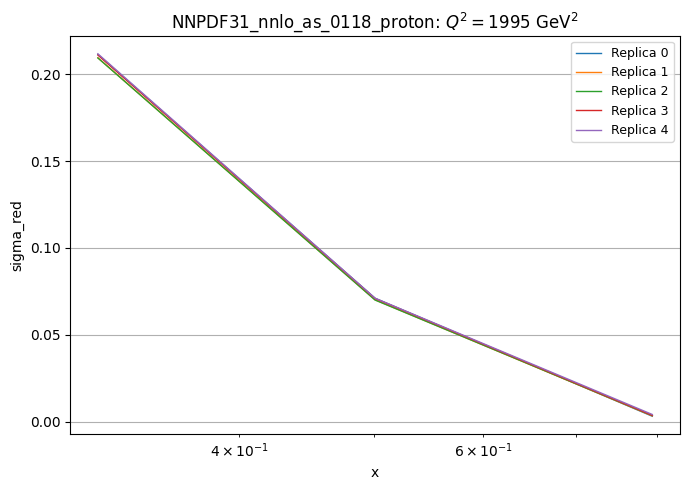

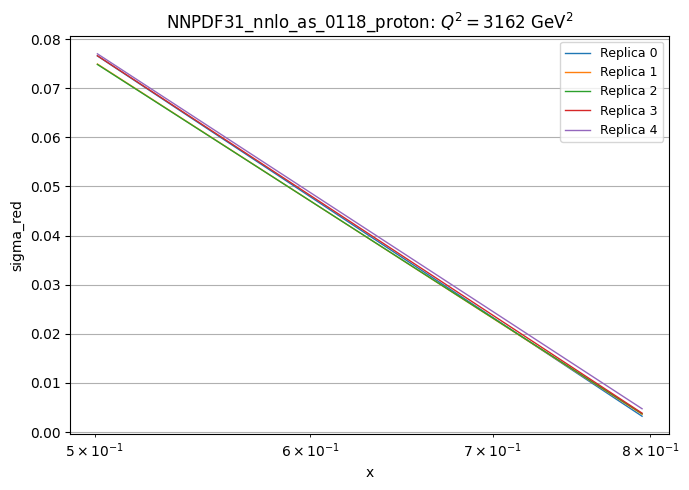

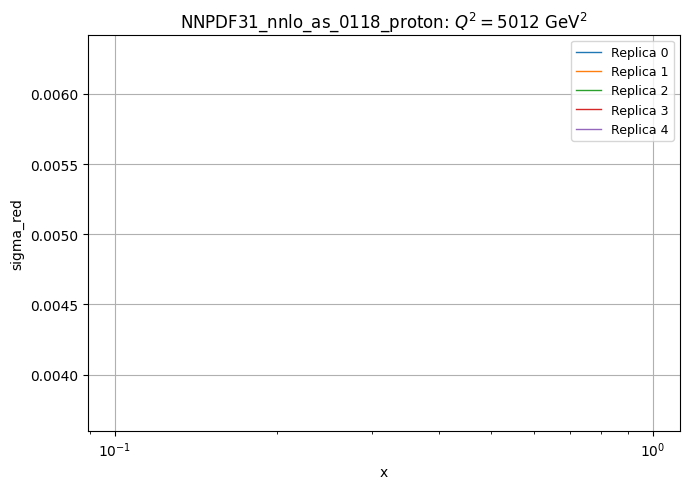

In [9]:
# Load the pre-computed grid
grid = pineappl.grid.Grid.read(f"../PineAPPL_grids/Xsec_Predictions_ep_Ee{eBeam}_Ep{pBeam}.{binning}.pineappl.lz4")

pdfset = "NNPDF31_nnlo_as_0118_proton"
# pdfset = "HERAPDF20_NNLO_EIG" # Don't use here - require eigenvector errors

# Convolve with the PDF for the central member
pdf = lhapdf.mkPDF(pdfset, 0)
yadism_data = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)

yadism_df = pd.concat(
    [
        data["Q2"],
        data["x"],
        data["y"],
        pd.DataFrame([yadism_data], index=["sigma_red_0"]).T,
    ],
    axis=1,
)
#yadism_df[["Q2", "x", "y", "sigma_red_0"]].to_csv(f"../Tables/{pdfset}_Ee{eBeam}_Ep{pBeam}_replica_0_Xsec.csv")

# Add data for 15 replicas
num_replicas = 5
for replica_index in range(1, num_replicas):
    # Redefine the PDF for each replica
    pdf = lhapdf.mkPDF(pdfset, replica_index)
    
    # Convolve with the Yadism grid again
    yadism_data = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)
    
    # Add the replica's data to the DataFrame
    yadism_df[f"sigma_red_{replica_index}"] = yadism_data

def plot_comparisons_q2(df: pd.DataFrame, q2_value: float = 139) -> None:
    """Plot Yadism predictions for multiple replicas."""
    fig, ax = plt.subplots(figsize=(7, 5), layout="tight")
    
    # Select corresponding Q2 values
    df_q2 = df[np.isclose(df['Q2'], q2_value, atol=0.01)]

    # Plot each replica as a line
    for replica_index in range(num_replicas):
        ax.plot(df_q2.x, df_q2[f"sigma_red_{replica_index}"], label=f"Replica {replica_index}", linestyle='-', linewidth=1)

    ax.set_xlabel("x")
    ax.set_ylabel("sigma_red")
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xscale("log")
    ax.set_title(f"{pdfset}: $Q^2 = {q2_value:.4g}~ \\mathrm{{GeV}}^2$")
    ax.grid(True)

    plt.savefig(f"../Plots/{pdfset}_Xsec_ep_Ee{eBeam}_Ep{pBeam}.{binning}_Q2_{q2_value:.4g}.png")



# Plot for Q^2 = 139 GeV^2
# plot_comparisons_q2(yadism_df, 2.7)
# plot_comparisons_q2(yadism_df, 500.)
#plt.show()

for Q2 in yadism_df['Q2'].unique():
    plot_comparisons_q2(yadism_df, Q2)
plt.show()

In [10]:
yadism_df # yadism_df[:30]

,Q2,x,y,sigma_red_0,sigma_red_1,sigma_red_2,sigma_red_3,sigma_red_4
0,1.258925,0.000200,0.630957,0.320509,0.355868,0.328610,0.301201,0.316824
1,1.258925,0.000316,0.398107,0.290023,0.345039,0.294617,0.269757,0.282573
2,1.258925,0.000501,0.251189,0.270261,0.288046,0.270341,0.247511,0.258629
3,1.258925,0.000794,0.158489,0.254951,0.264581,0.252288,0.230690,0.242074
4,1.258925,0.001259,0.100000,0.240664,0.237936,0.238642,0.215656,0.230358
...,...,...,...,...,...,...,...,...
149,1995.262315,0.501187,0.398107,0.070988,0.070120,0.069969,0.070835,0.071018
150,1995.262315,0.794328,0.251189,0.003073,0.003301,0.003510,0.003564,0.004079
151,3162.277660,0.501187,0.630957,0.076566,0.074909,0.074827,0.076604,0.076990
152,3162.277660,0.794328,0.398107,0.003222,0.003631,0.003733,0.003843,0.004745


LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0000.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #0, version 1; LHAPDF ID = 316900
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0001.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #1, version 1; LHAPDF ID = 316901
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0002.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #2, version 1; LHAPDF ID = 316902
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0003.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #3, version 1; LHAPDF ID = 316903
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0004.dat
NNPDF31_nnlo_as_0118_proton PDF set, m

/tmp/ipykernel_15788/1844897936.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  yadism_df[f"sigma_red_{replica_index}"] = yadism_data
/tmp/ipykernel_15788/1844897936.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  yadism_df[f"sigma_red_{replica_index}"] = yadism_data
/tmp/ipykernel_15788/1844897936.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

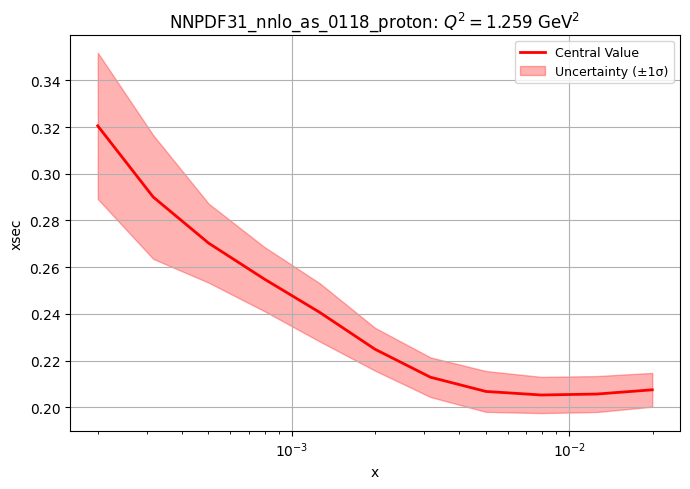

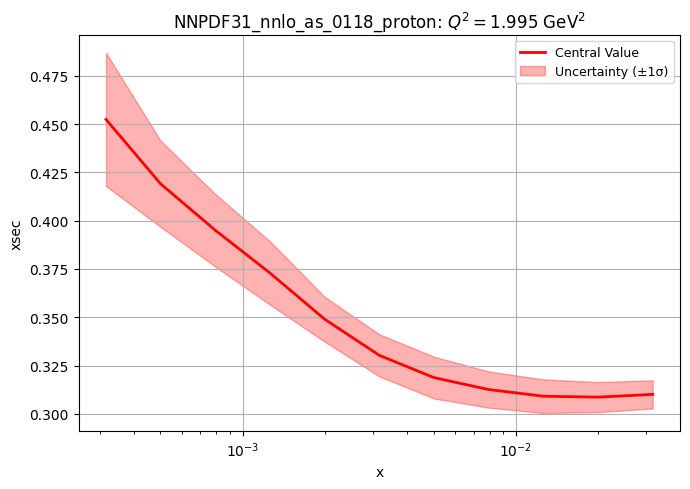

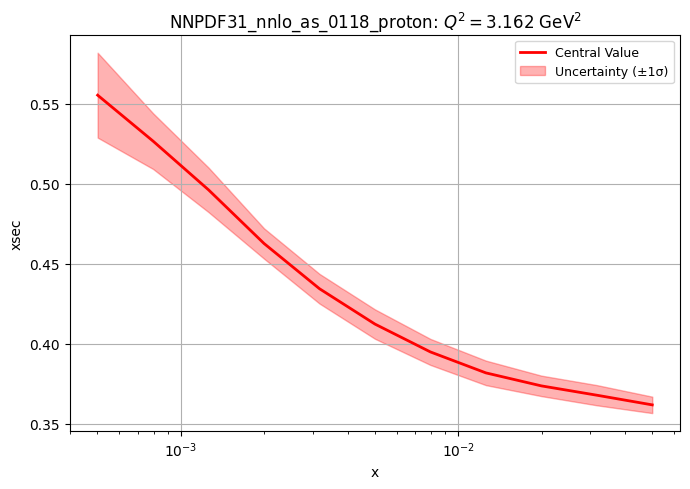

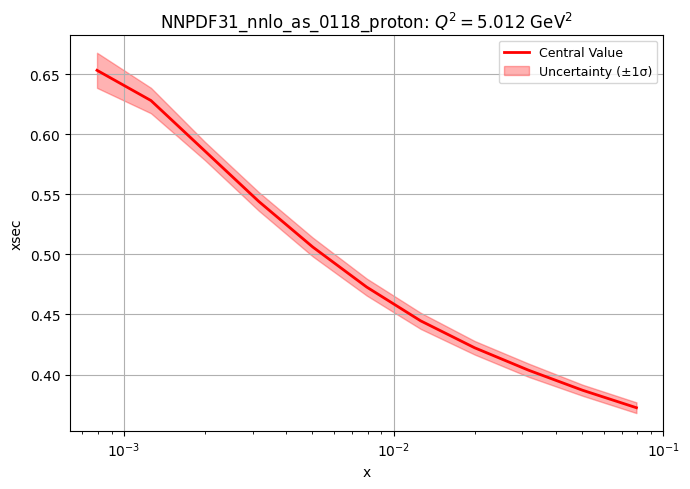

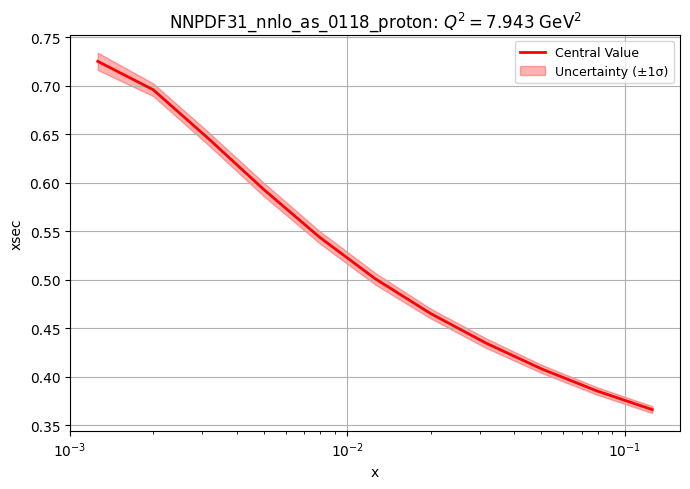

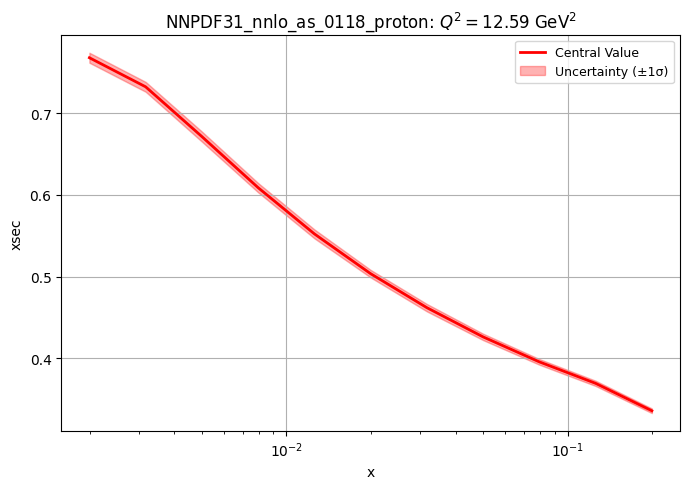

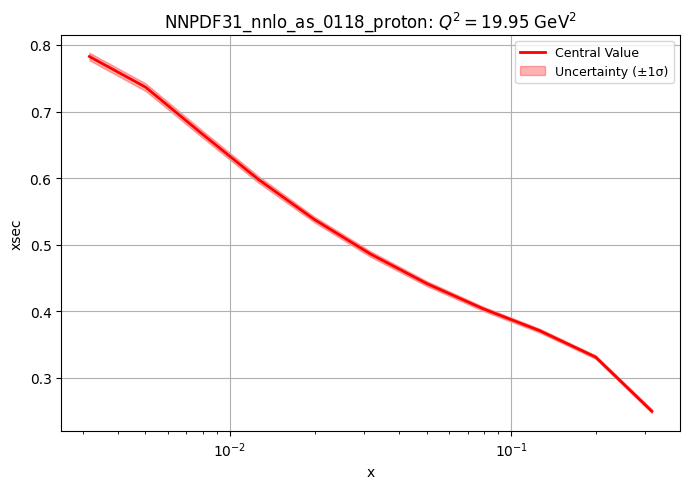

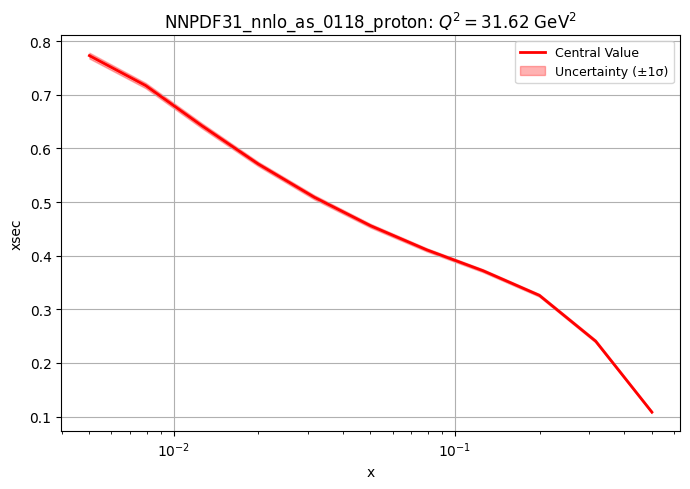

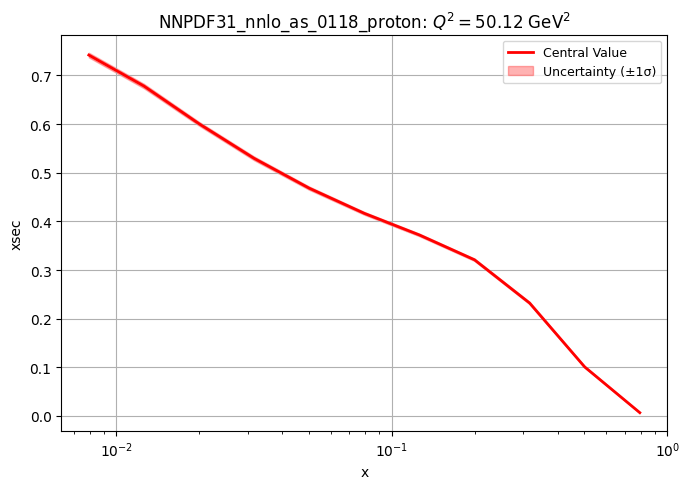

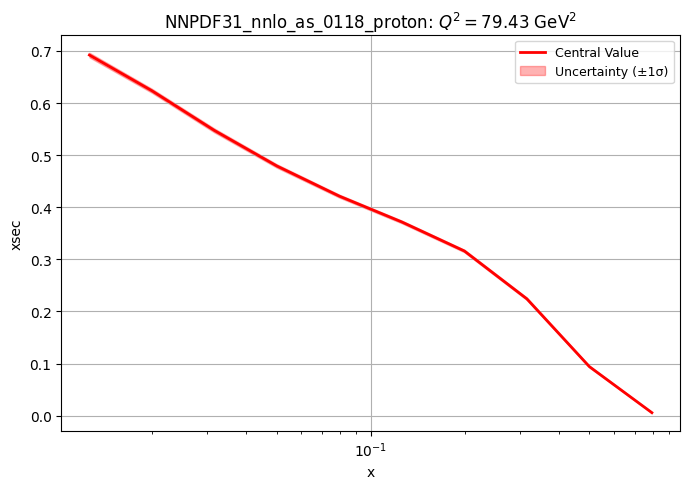

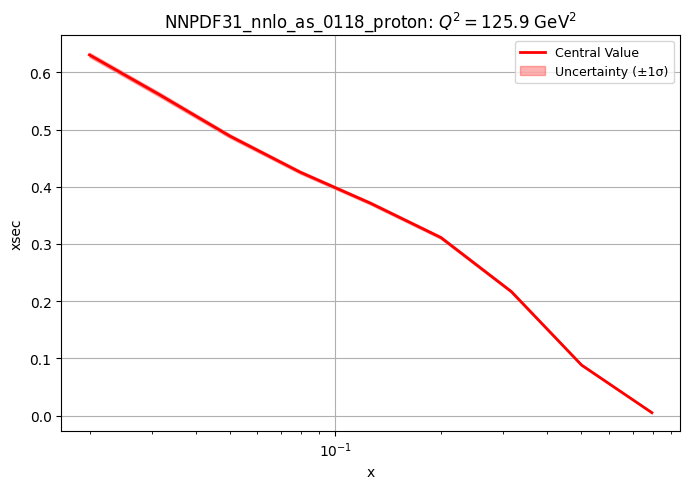

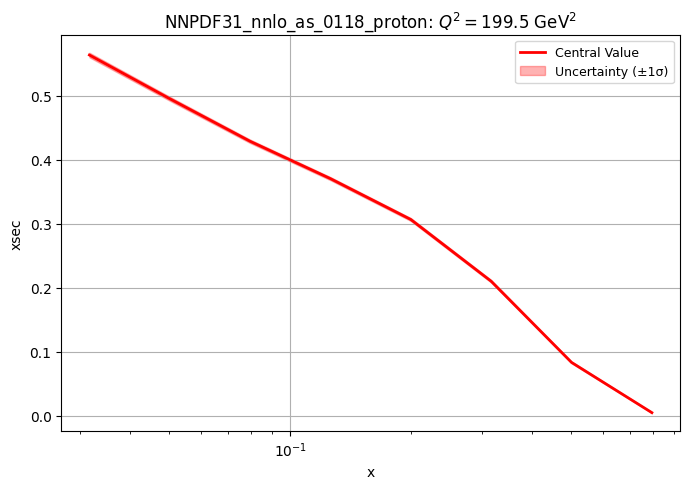

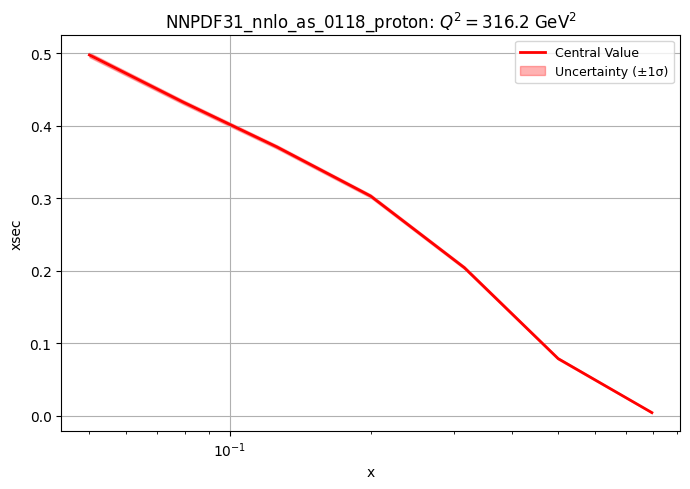

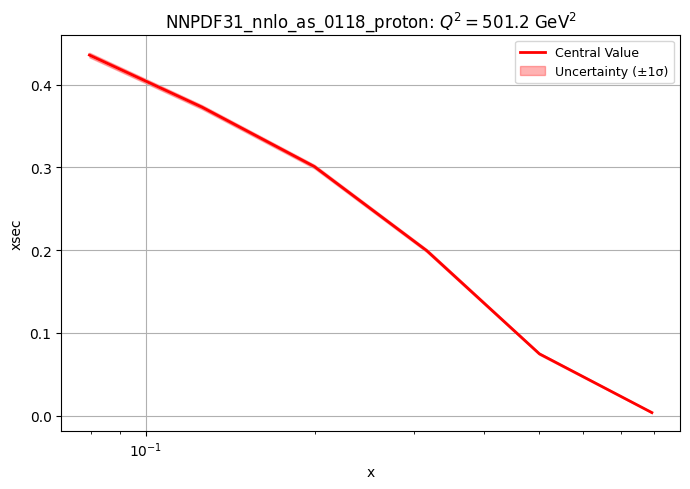

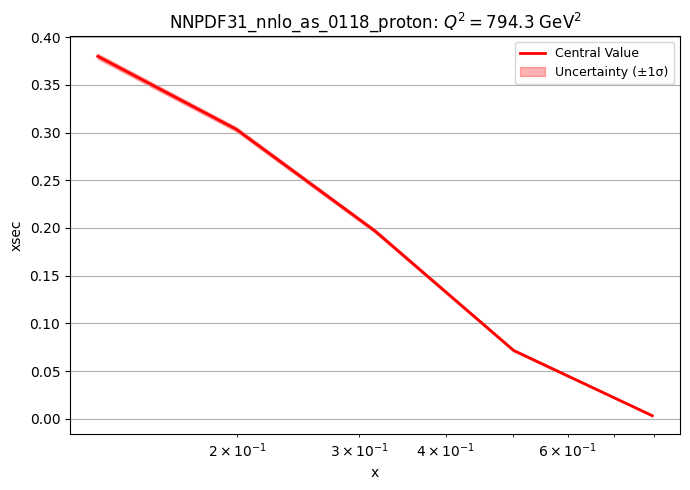

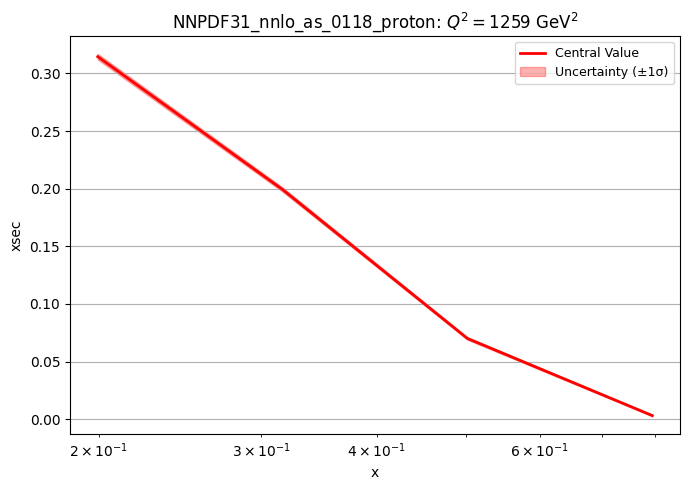

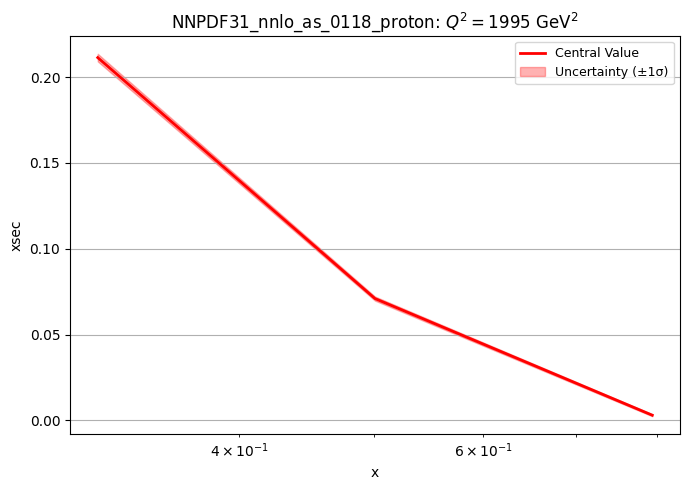

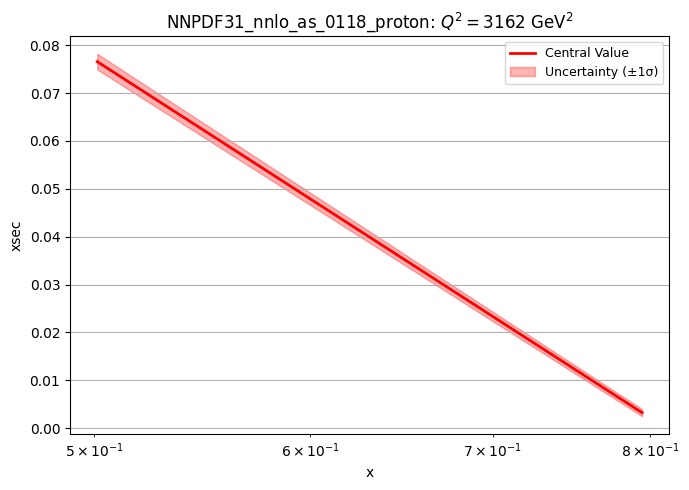

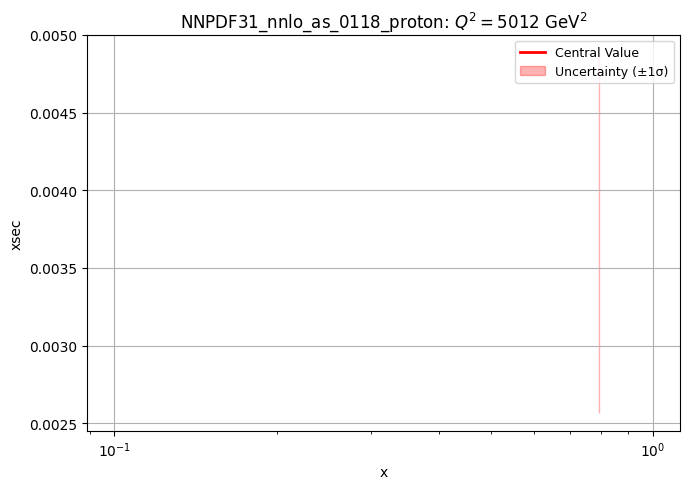

In [11]:
# TODO: Fix PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times
# Will likely require changing how I manage the df

# Load the pre-computed grid
grid = pineappl.grid.Grid.read(f"../PineAPPL_grids/Xsec_Predictions_ep_Ee{eBeam}_Ep{pBeam}.{binning}.pineappl.lz4")

# Set PDF set
pdfset = "NNPDF31_nnlo_as_0118_proton"

# Number of replicas
num_replicas = 5

if ("NNPDF" in pdfset):
    error_type = "mc_replica"
    num_replicas = 100


# Initialise DataFrame with central value (replica 0)
pdf = lhapdf.mkPDF(pdfset, 0)
yadism_data = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)

yadism_df = pd.concat(
    [
        data["Q2"],
        data["x"],
        data["y"],
        pd.DataFrame([yadism_data], index=["sigma_red_0"]).T,
    ],
    axis=1,
)

# Add data for remaining replicas
for replica_index in range(1, num_replicas):
    pdf = lhapdf.mkPDF(pdfset, replica_index)
    yadism_data = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)
    yadism_df[f"sigma_red_{replica_index}"] = yadism_data

# Compute standard deviation across all replicas (uncertainty)
replica_columns = [f"sigma_red_{i}" for i in range(1, num_replicas)]  # Excluding central value

if (error_type == "mc_replica"):
    yadism_df["sigma_red_unc"] = yadism_df[replica_columns].std(axis=1, ddof=1)  # Sample standard deviation

print(f"Using {error_type} approach for errors")

# Define function for plotting w/ error bands
def plot_expectation_q2(df: pd.DataFrame, q2_value: float = 139) -> None:
    """Plot central value with uncertainty for a given Q² value."""
    fig, ax = plt.subplots(figsize=(7, 5), layout="tight")

    # Select corresponding Q2 values
    df_q2 = df[np.isclose(df['Q2'], q2_value, atol=0.01)]

    # Plot central value
    ax.plot(df_q2.x, df_q2["sigma_red_0"], label="Central Value", color="r", linestyle="-", linewidth=2)

    # Plot shaded uncertainty region
    ax.fill_between(df_q2.x, df_q2["sigma_red_0"] - df_q2["sigma_red_unc"], 
                                df_q2["sigma_red_0"] + df_q2["sigma_red_unc"], 
                    color="r", alpha=0.3, label="Uncertainty (±1σ)")

    ax.set_xlabel("x")
    ax.set_ylabel("xsec")
    ax.set_xscale("log")
    ax.set_title(f"{pdfset}: $Q^2 = {q2_value:.4g}~ \\mathrm{{GeV}}^2$")
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True)

    plt.savefig(f"../Plots/{pdfset}_Xsec_ep_Ee{eBeam}_Ep{pBeam}.{binning}_Q2_{q2_value:.4g}.png")

# Plot for Q^2 = 10^0.7 and 10^2.3
# plot_expectation_q2(yadism_df, 2.0)
# plot_expectation_q2(yadism_df, 500.)
# plt.show()

for Q2 in data['Q2'].unique():
    plot_expectation_q2(yadism_df, Q2)
plt.show()

In [12]:
yadism_df

,Q2,x,y,sigma_red_0,sigma_red_1,sigma_red_2,sigma_red_3,sigma_red_4,sigma_red_5,sigma_red_6,...,sigma_red_91,sigma_red_92,sigma_red_93,sigma_red_94,sigma_red_95,sigma_red_96,sigma_red_97,sigma_red_98,sigma_red_99,sigma_red_unc
0,1.258925,0.000200,0.630957,0.320509,0.355868,0.328610,0.301201,0.316824,0.369837,0.328954,...,0.322502,0.339795,0.328387,0.387279,0.260587,0.412138,0.314854,0.313928,0.292025,0.031323
1,1.258925,0.000316,0.398107,0.290023,0.345039,0.294617,0.269757,0.282573,0.326566,0.297290,...,0.291121,0.301611,0.297216,0.344181,0.246524,0.362747,0.290675,0.286175,0.275361,0.026500
2,1.258925,0.000501,0.251189,0.270261,0.288046,0.270341,0.247511,0.258629,0.269230,0.272957,...,0.269520,0.275803,0.277259,0.317931,0.207159,0.276905,0.272060,0.264826,0.261128,0.016928
3,1.258925,0.000794,0.158489,0.254951,0.264581,0.252288,0.230690,0.242074,0.244923,0.252847,...,0.251824,0.260388,0.263082,0.256813,0.188533,0.261988,0.256488,0.247212,0.248737,0.013751
4,1.258925,0.001259,0.100000,0.240664,0.237936,0.238642,0.215656,0.230358,0.229265,0.236623,...,0.236055,0.244620,0.247805,0.255595,0.185945,0.240021,0.243319,0.232474,0.232163,0.012491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,1995.262315,0.501187,0.398107,0.070988,0.070120,0.069969,0.070835,0.071018,0.071783,0.070162,...,0.068877,0.072596,0.072011,0.069539,0.071123,0.070417,0.069570,0.071094,0.070797,0.001181
150,1995.262315,0.794328,0.251189,0.003073,0.003301,0.003510,0.003564,0.004079,0.002671,0.004049,...,0.001043,0.003413,0.002821,0.003257,0.003116,0.001917,0.002939,0.002945,0.003005,0.000597
151,3162.277660,0.501187,0.630957,0.076566,0.074909,0.074827,0.076604,0.076990,0.076782,0.075035,...,0.073172,0.079653,0.077359,0.075282,0.076892,0.075630,0.074385,0.076281,0.076847,0.001639
152,3162.277660,0.794328,0.398107,0.003222,0.003631,0.003733,0.003843,0.004745,0.002529,0.004327,...,0.000770,0.003719,0.002944,0.003518,0.003202,0.002058,0.002878,0.003158,0.003097,0.000747


In [13]:
yadism_df[['Q2', 'x', 'y', 'sigma_red_0', 'sigma_red_unc']].to_csv(f"../Tables/{binning}_{method}_Ee{eBeam}_Ep{pBeam}_{pdfset}_XsecPredictions.csv",index=False)

In [14]:
herapdf_df = pd.read_csv(f"../HERAPDF_Xsec_Tables/{binning}/herapdf2nnlo-{eBeam}x{pBeam}",names=['Q2','x','y','sigma_red_0','sigma_red_unc_+','sigma_red_unc_-'],sep='\s+')

FileNotFoundError: [Errno 2] No such file or directory: '../HERAPDF_Xsec_Tables/StandardBinning/herapdf2nnlo-10x250'

In [79]:
herapdf_df

,Q2,x,y,sigma_red_0,sigma_red_unc_+,sigma_red_unc_-
0,3.5,0.0020,0.67308,0.528680,0.006150,0.010319
1,3.5,0.0032,0.42067,0.512800,0.006112,0.009579
2,3.5,0.0050,0.26923,0.487620,0.006207,0.008971
3,3.5,0.0080,0.16827,0.461150,0.006218,0.008162
4,3.5,0.0130,0.10355,0.437260,0.006067,0.007133
...,...,...,...,...,...,...
186,800.0,0.4000,0.76923,0.150300,0.001942,0.002093
187,800.0,0.6500,0.47337,0.020000,0.000691,0.000706
188,1000.0,0.6500,0.59172,0.019828,0.000698,0.000703
189,1200.0,0.6500,0.71006,0.019843,0.000715,0.000707


In [80]:
herapdf_df.to_csv(f"../Tables/{binning}_{method}_Ee{eBeam}_Ep{pBeam}_HERAPDF2_XsecPredictions_AsymErr.csv",index=False)

/tmp/ipykernel_10395/2994205754.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, 5), layout="tight")


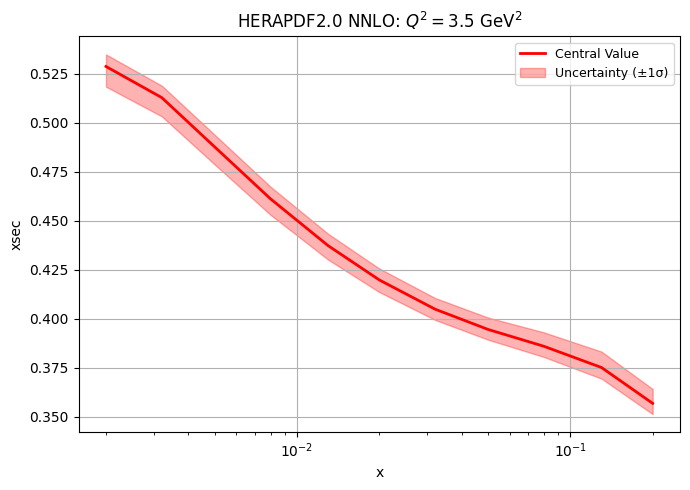

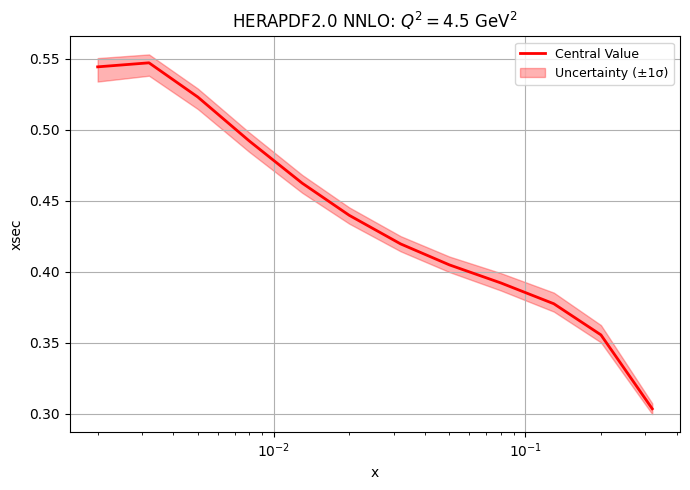

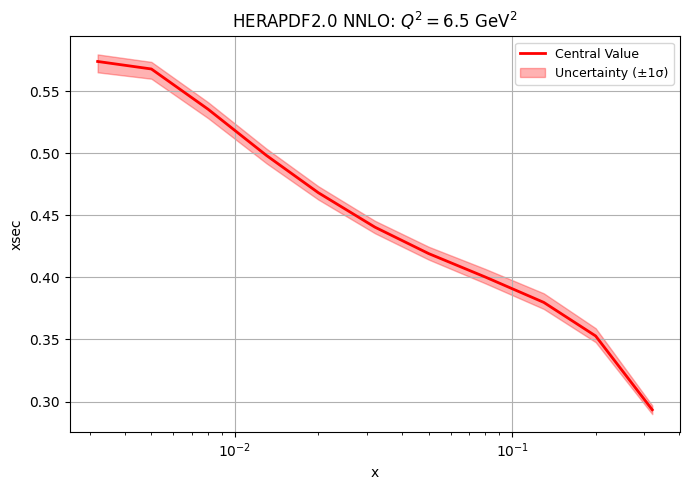

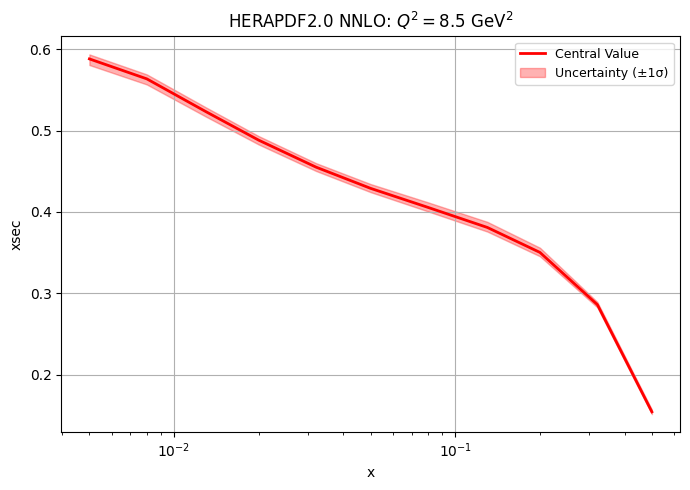

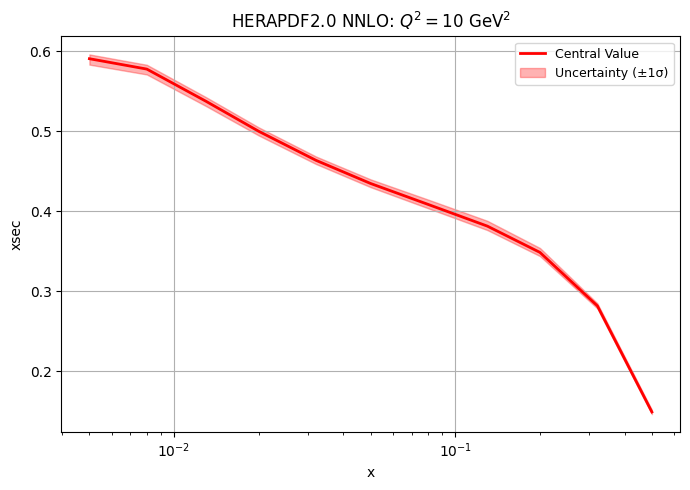

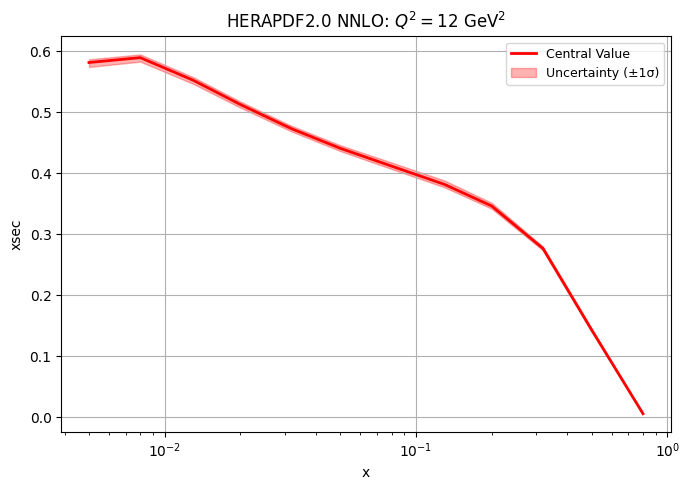

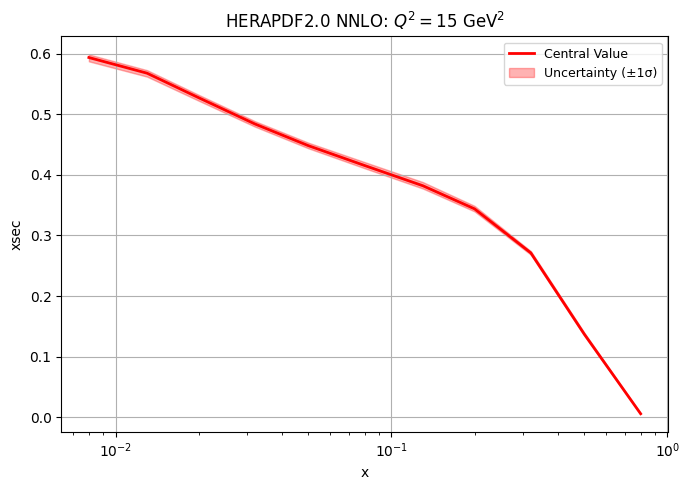

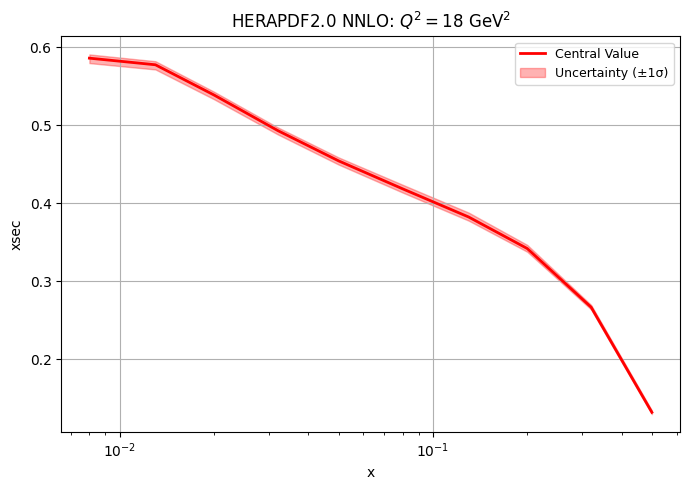

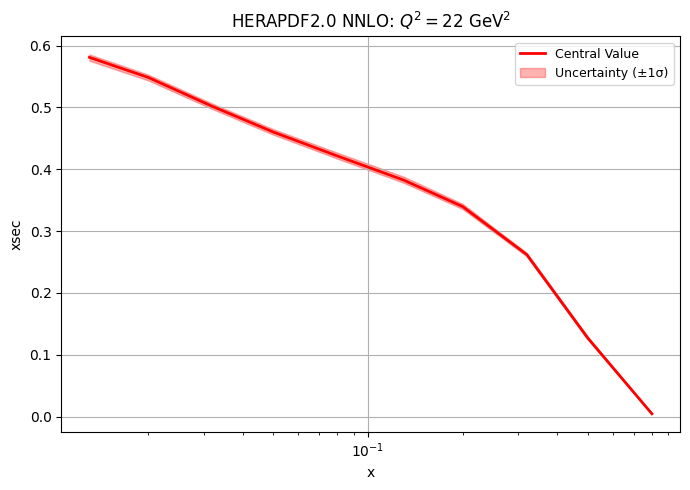

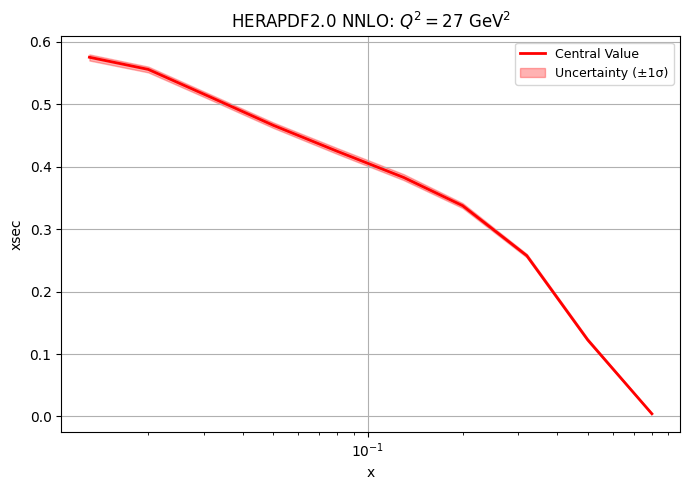

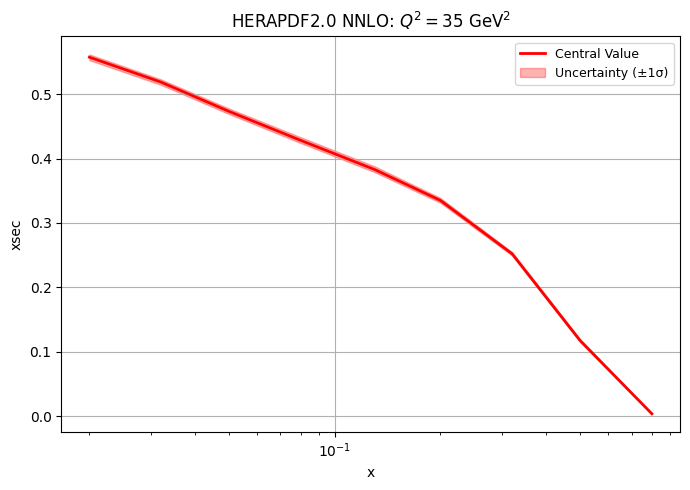

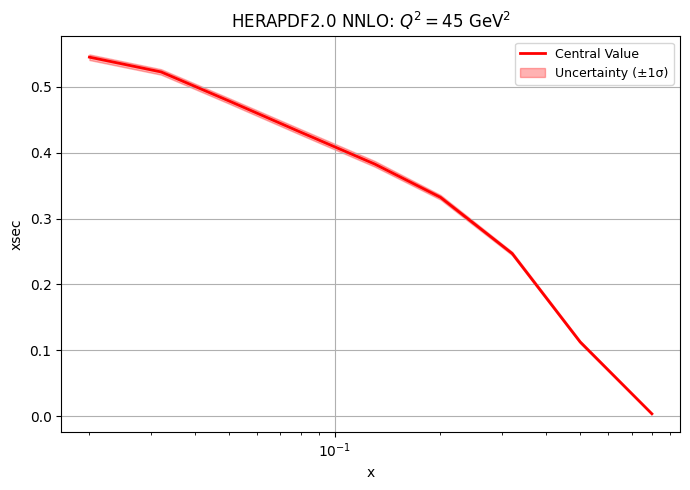

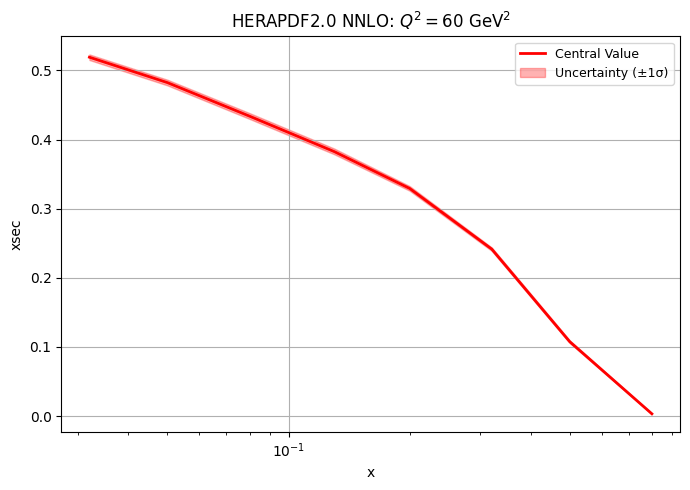

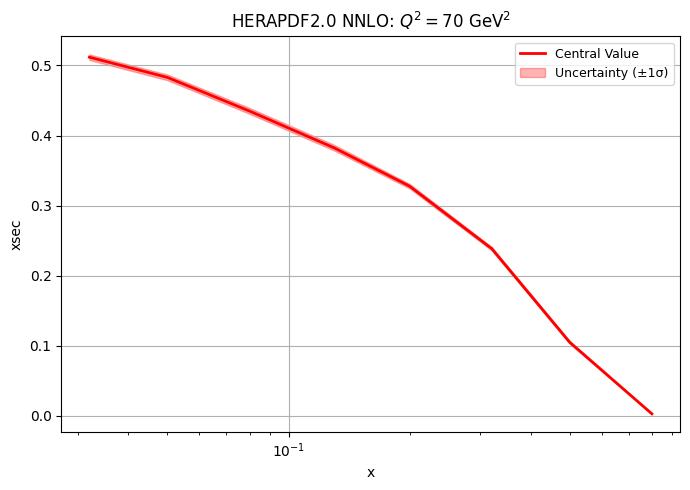

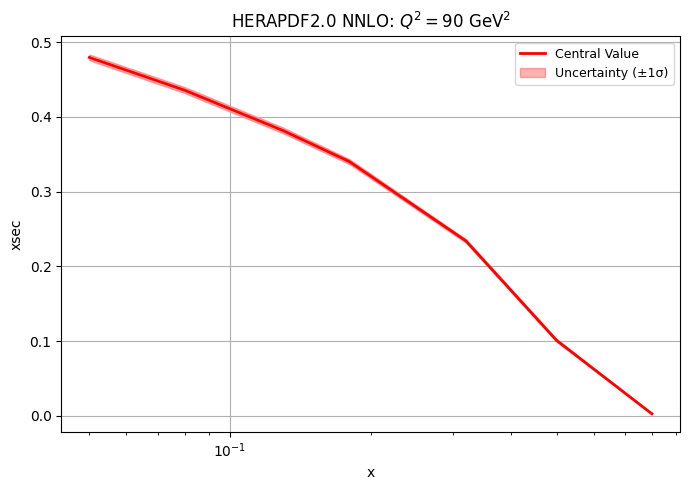

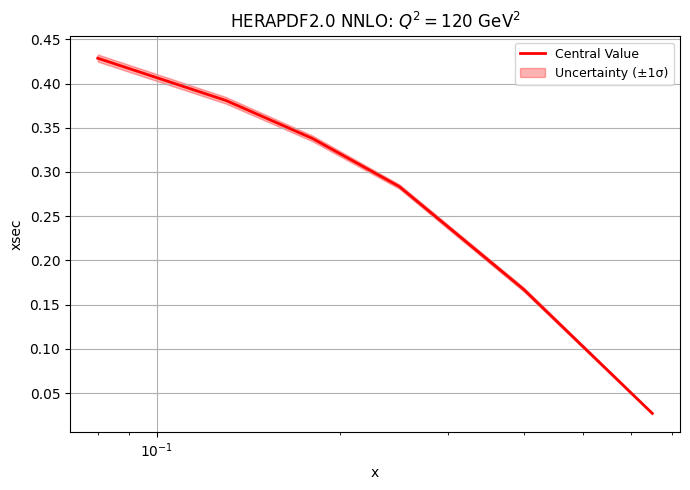

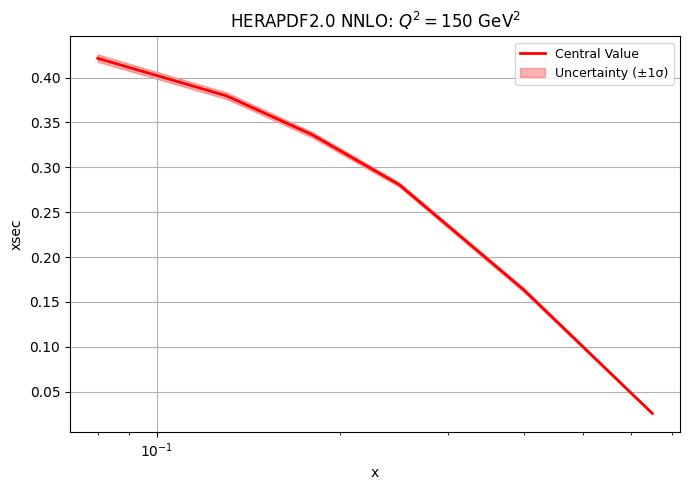

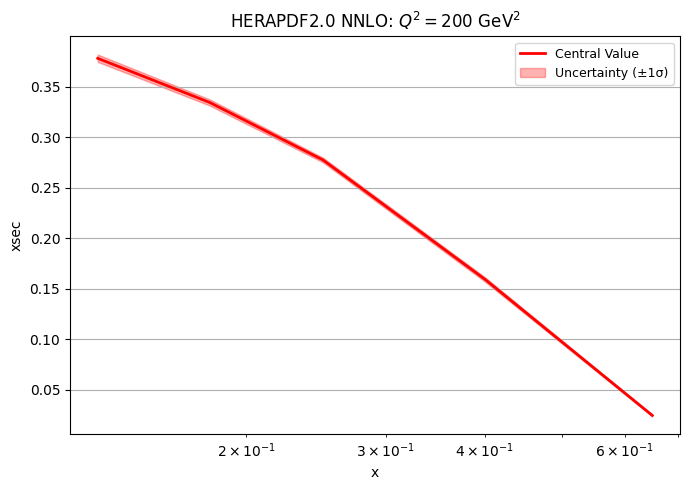

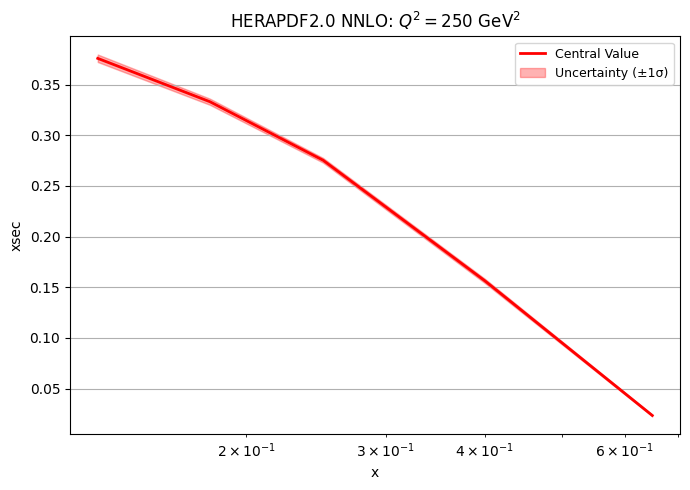

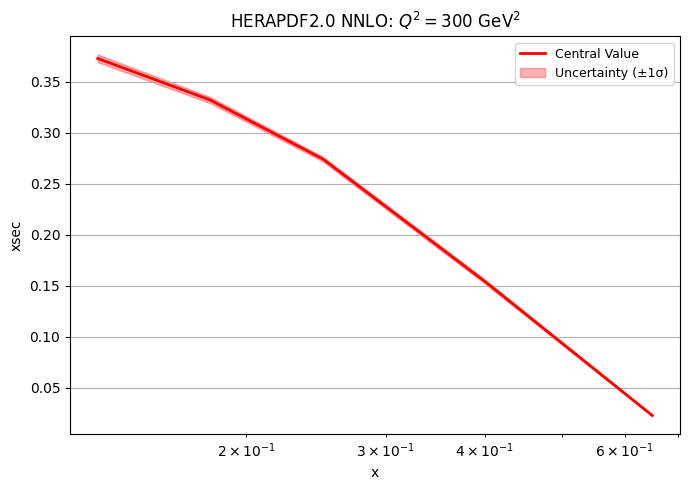

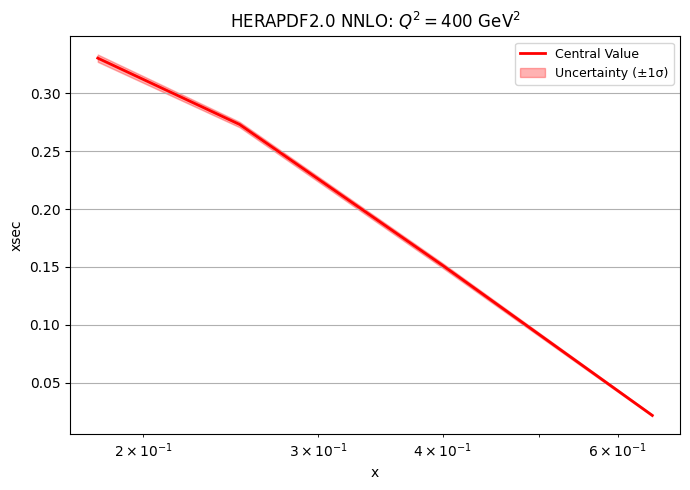

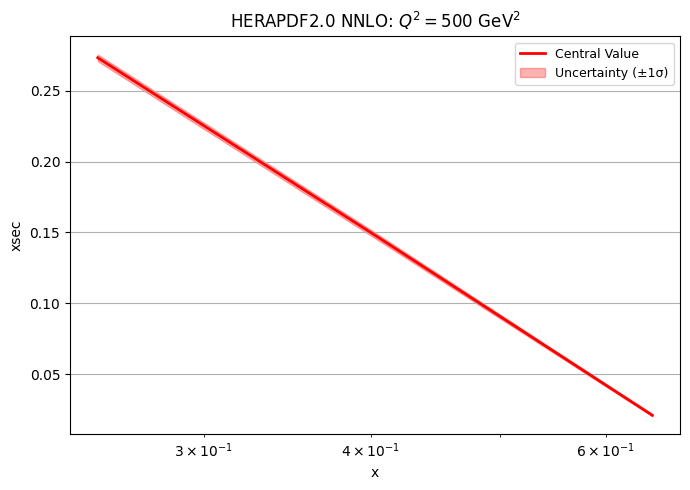

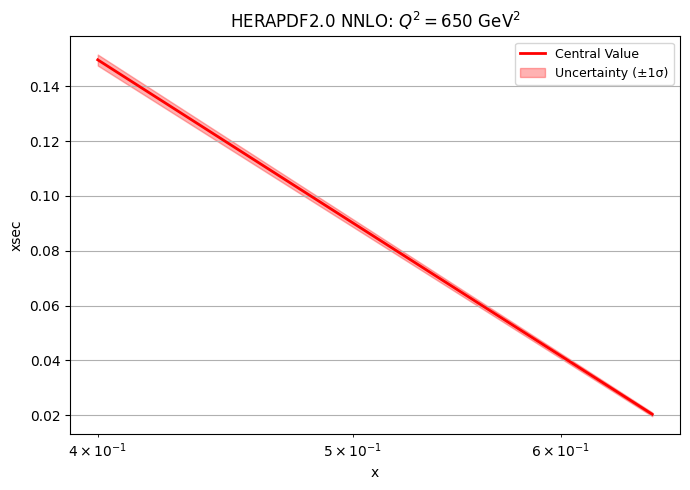

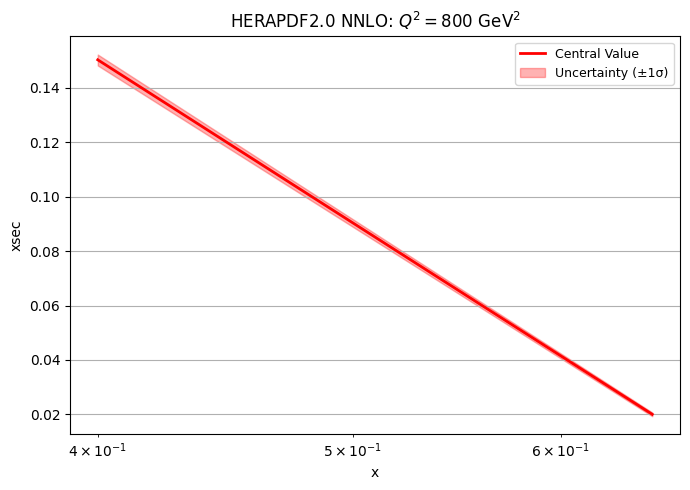

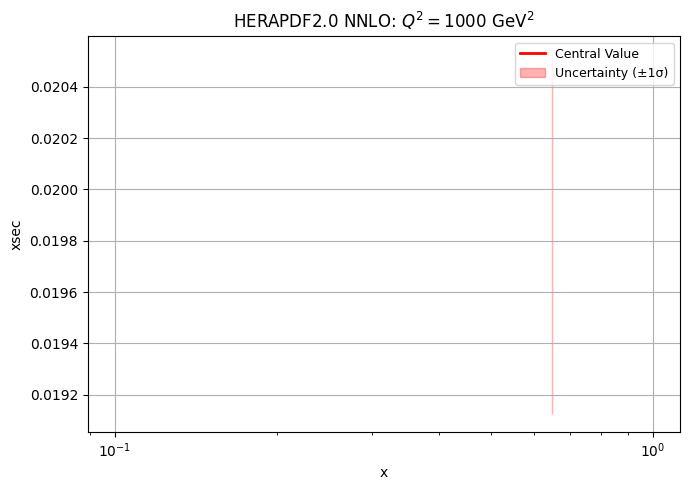

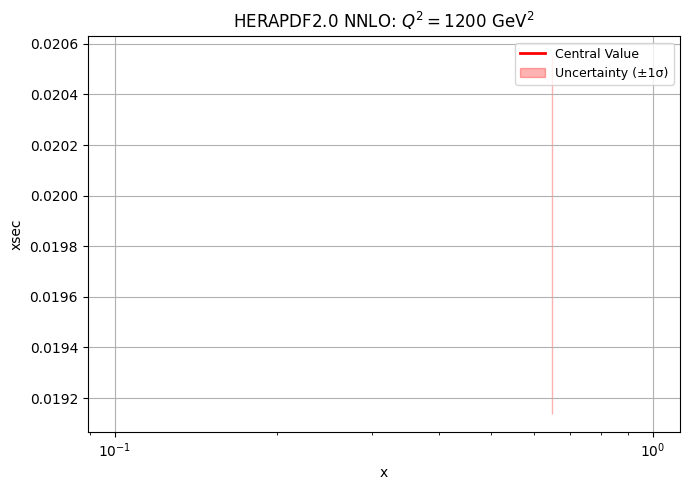

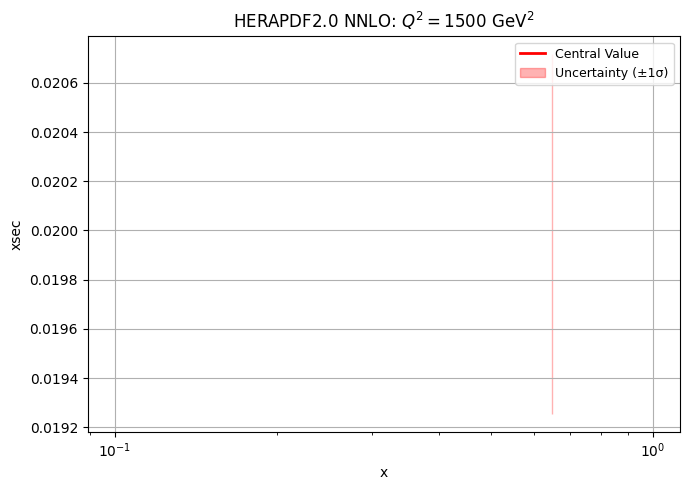

In [81]:
def plot_expectation_q2_asym(df: pd.DataFrame, q2_value: float = 139) -> None:
    """Plot central value with asymmetric uncertainty for a given Q² value."""
    fig, ax = plt.subplots(figsize=(7, 5), layout="tight")

    # Select corresponding Q2 values
    df_q2 = df[np.isclose(df['Q2'], q2_value, atol=0.01)]

    # Central value
    ax.plot(df_q2.x, df_q2["sigma_red_0"],
            label="Central Value", color="r",
            linestyle="-", linewidth=2)

    # Asymmetric uncertainty band
    lower = df_q2["sigma_red_0"] - df_q2["sigma_red_unc_-"]
    upper = df_q2["sigma_red_0"] + df_q2["sigma_red_unc_+"]

    ax.fill_between(df_q2.x, lower, upper,
                    color="r", alpha=0.3,
                    label="Uncertainty (±1σ)")

    ax.set_xlabel("x")
    ax.set_ylabel("xsec")
    ax.set_xscale("log")
    ax.set_title(f"HERAPDF2.0 NNLO: $Q^2 = {q2_value:.4g}~ \\mathrm{{GeV}}^2$")
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True)

    plt.savefig(f"../Plots/HERAPDF2.0_NNLO_Asym_Xsec_ep_Ee{eBeam}_Ep{pBeam}.{binning}_Q2_{q2_value:.4g}.png")

for Q2 in herapdf_df['Q2'].unique():
    plot_expectation_q2_asym(herapdf_df, Q2)
plt.show()